# Assignment 1

**Authors:**
- Krish Devendra Waghresha (s252788)
- Javier Yanes Pulido (s243345)
- Jone Egon Steinhoff (s243867)

## 1.1: Exploring WS and BA models

### 1.1.1: Did you really read the text?

**What's the problem with random networks as a model for real-world networks according to the argument in section 3.5 (near the end)?**

Random (Erdős-Rényi) networks do not capture the degree distribution of real-world networks: in real networks, some people can have thousands of friends (hubs), whereas such high-degree nodes are extremely unlikely in random networks. As a result, random networks fail to reproduce the heavy-tailed structure seen in real networks.

**List the four regimes that characterize random networks as a function of $\langle k \rangle$.**

We have, for $\langle k \rangle$ being the mean number of connections (edges) per node in the network:
- $\langle k \rangle < 1$ (Subcritical regime): The network is fragmented; only many small disconnected components exist; clusters are trees.
- $\langle k \rangle = 1$ (Critical point): Critical point; the size of the largest component starts to diverge; from this point clusters start containing loops.
- $\langle k \rangle > 1$ (Supercritical regime): A giant component exists containing a finite fraction of nodes, but not all nodes are part of it.
- $\langle k \rangle \gg ln(N)$ (Connected regime): The network becomes fully connected; single giant component; no isolated nodes or clusters.

**According to the book, why is it a problem for random networks (in terms of being a model for real-world networks) that the degree-dependent clustering $C(k)$ decreases as a function of $k$ in real-world networks?**

In random networks, the clustering coefficient $C(k)$ is independent of the node degree $k$ and is typically very small (decays as $1/N$). However, in most real-world networks, $C(k)$ decreases with $k$: nodes with few connections have higher clustering, while hubs have lower clustering. Also, in real networks local clustering is largely independent of the system size.

### 1.1.2: WS edition

**First, let's use `networkx` to play around with WS graphs. Use `nx.watts_strogatz_graph` to generate 3 graphs with 500 nodes each, average degree = 4, and rewiring probablity $p = 0, 0.1,$ and  $1$. Calculate the average shortest path length $\langle d \rangle$ for each one.**

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import re
import pandas as pd

Avg. shortest path length for p =  0 :  62.88
Avg. shortest path length for p =  0.1 :  7.92
Avg. shortest path length for p =  1.0 :  4.77


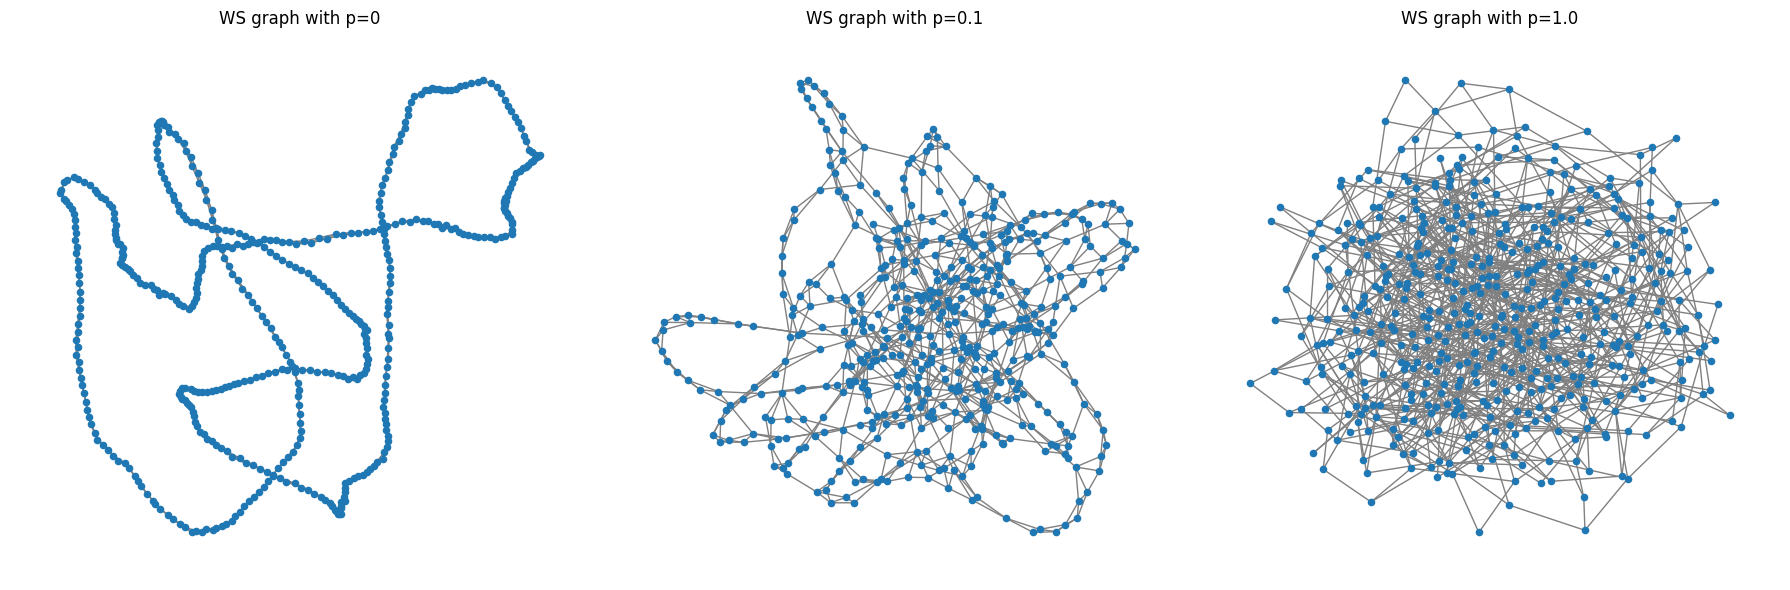

In [3]:
n = 500
k = 4
p_values = [0, 0.1, 1.0]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, p in zip(axes, p_values):
    G = nx.watts_strogatz_graph(n, k, p)

    # calculating the avg. shortest path length of each graph
    spl = nx.average_shortest_path_length(G)
    print("Avg. shortest path length for p = ", p, ": ", round(spl, 2))
    pos = nx.spring_layout(G)
    
    nx.draw(
        G, pos, ax=ax,
        node_size=20, edge_color='gray'
    )
    ax.set_title(f"WS graph with p={p}")

plt.tight_layout()
plt.show()

_**Fig. 1:** "Visualization of three Watts–Strogatz (WS) graphs with $n=500$ nodes and $k=4$ neighbors per node, for different rewiring probabilities $p=0$, $p=0.1$, and $p=1.0$. The plots illustrate the transition from a regular lattice ($p=0$) to a small-world network ($p=0.1$) and finally to a random network ($p=1.0$)."_

**Describe what happens to the network when $p = 1$?**\
When $p=1$ in the Watts-Strogatz model, all edges are rewired randomly, so the network behaves like an Erdős-Rényi (random) graph with the same number of nodes and edges but no underlying regular structure. This means the original local clustering is lost, and connections become completely random, resulting in short average path lengths like a random graph but low clustering. In other words, for each edge, with probability $p=1$ the edge is disconnected from its initial neighboring node and reconnected to another randomly selected node (while avoiding duplicates and self-loops).

**Generate a lot of networks with different values of $p$. You will notice that paths are short when $p$ is close to one and they are long when $p = 0$. What's the value of $p$ for which the average shortest path length gets close to the short paths we find in a fully randomized network.**

In [4]:
def avg_spl_WS(N, k, p, n):
    spls = []
    for _ in range(n):
        WS = nx.watts_strogatz_graph(N, k, p)
        path = nx.average_shortest_path_length(WS)
        spls.append(path)

    avg_spls = np.average(spls)
    std_spls = np.std(spls)

    return avg_spls, std_spls

In [5]:
ps = [0, 0.01, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1] # from 0.3 to 1 are just for experimenting for this question
N = 500
k = 4

avgs = []
stds = []
for p in ps:
    avg, std = avg_spl_WS(N, k, p, 1)
    avgs.append(avg)
    stds.append(std)

print([round(x, 2) for x in avgs])

[np.float64(62.88), np.float64(24.46), np.float64(13.81), np.float64(9.64), np.float64(7.98), np.float64(6.32), np.float64(5.39), np.float64(4.94), np.float64(4.84), np.float64(4.74)]


$$
\bar{\ell} \;\approx\; \frac{\ln 500}{\ln 4}.
$$

Using the formula above, given in Barabási, A.-L. (2016). Network Science. Cambridge University Press. **Box 3.11**, to calculate the average shortest path, we get $\approx 4.482$. For the shortest path for the $p=1$ case, we get the closest number: $\approx 4.76$. Therefore, $p=1$ is the value for which the average shortest path length gets closer to the short paths we find in a fully randomized network. 

**Let's investigate this behavior in detail. Generate 50 networks with $N = 500$, $\langle k \rangle = 4$, for each of $p = \{0, 0.01, 0.03, 0.05, 0.1, 0.2\}$. Calculate the average of $\langle d \rangle$ as well as the standard deviation over the 50 networks, to create a plot that shows how the path length decreases very quickly with only a little fraction of re-wiring. Use the standard deviation to add [errorbars](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html) to the plot. My version of the plot is below (since a picture's worth 1000 words).**

In [6]:
ps = [0, 0.01, 0.03, 0.05, 0.1, 0.2]
N = 500
k = 4

avgs = []
stds = []
for p in ps:
    avg, std = avg_spl_WS(N, k, p, 50)
    avgs.append(avg)
    stds.append(std)

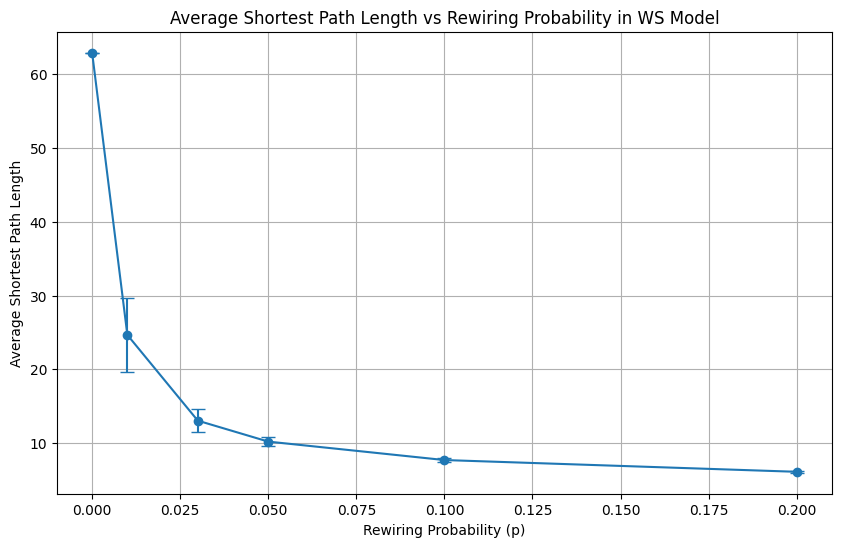

In [7]:
# Plot with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(ps, avgs, yerr=stds, marker='o', capsize=5)
plt.xlabel('Rewiring Probability (p)')
plt.ylabel('Average Shortest Path Length')
plt.title('Average Shortest Path Length vs Rewiring Probability in WS Model')
plt.grid(True)
plt.show()

**Imagine that you put this plot in an assignment. Write a figure caption that explains to the reader what the plot shows (which variables, etc) and what's interesting about it.**

_"**Fig. 2:** Average shortest path length $⟨d⟩$ versus rewiring probability $p$ in the Watts-Strogatz small-world model for networks with 500 nodes and average degree 4, with error bars representing one standard deviation over 50 realizations."_

At $p=0$, the network is a regular ring lattice, so every run gives the same path length and the variance is zero (i.e. deterministic). For small $p$, a few random shortcuts can greatly change distances depending on where they appear, causing a spike in variance. As $p$ grows, more shortcuts make path lengths more uniform, so the variance drops and approaches zero again near $p=1$. At the same time, the average shortest path steadily decreases with $p$, since shortcuts reduce the number of steps needed to connect distant nodes.

### 1.1.3: BA Edition

**What are the three slope dependent regimes of complex networks with power-law degree distributions? Briefly describe each one. (You will have to skim chp 4.7 to answer this one).**

- Anomalous Regime ($\gamma \leq 2$): The degree of the largest hub exceeds the total number of nodes, therefore needing special rules like loops. Also, the average degree is infinite.
- Scale-Free Regime ($2 < \gamma < 3$): "Realistic network", hubs dont grow faster than the network but still grow with it and the variance of node degrees grows. The average degree is finite but the variance is infinite.
- Random Network Regime ($\gamma > 3$): Both the average degree and variance are finite. There are no significant hubs and it looks like a random network.

**What are the three regimes we find in non-linear preferential attachement? (chapter 5) Briefly describe each one.**

- Sublinear regime ($\alpha < 1$): Popular nodes are fairly attractive and the degree distribution is stretched exponential.
- Linear regime ($\alpha =1$): Popular nodes are attractive and the degree distribution follows the true power law.
- Superlinear regime ($\alpha >1$): Popular nodes are very attractive and eventually one hub gets all or most of the links.

**First create a graph consisting of a single link. (You can call the nodes anything, but I would simply use integers as names).**

In [8]:
G = nx.Graph()
G.add_edge(0, 1)

**Now add another node, connecting one of the existing nodes in proportion to their degree.**

In [9]:
degrees = [G.degree(n) for n in G.nodes()]
current_nodes = list(G.nodes())
G.add_node(2)
G.add_edge(2, random.choices(current_nodes, weights=degrees)[0])

**Keep going until you have a 100 node network.**

In [10]:
while G.number_of_nodes() < 100:
    new_node = G.number_of_nodes()
    degrees = [G.degree(n) for n in G.nodes()]
    current_nodes = list(G.nodes())
    G.add_node(new_node)
    G.add_edge(new_node, random.choices(current_nodes, weights=degrees)[0])

**Plot the network.**

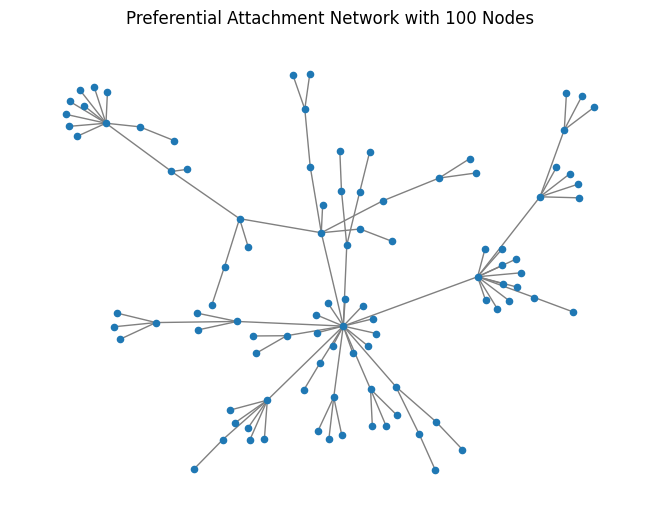

In [11]:
nx.draw(G, node_size=20, edge_color='gray')
plt.title(f"Preferential Attachment Network with {G.number_of_nodes()} Nodes")
plt.show()

_**Fig. 3:** "Visualization of the preferential attachment network with 100 nodes"_

**Add more nodes until you have a 5000 node network.**

In [12]:
while G.number_of_nodes() < 5000:
    new_node = G.number_of_nodes()
    degrees = [G.degree(n) for n in G.nodes()]
    current_nodes = list(G.nodes())
    G.add_node(new_node)
    G.add_edge(new_node, random.choices(current_nodes, weights=degrees)[0])

**What's the maximum and minimum degree?**

In [13]:
max_degree = max(dict(G.degree()).values())
min_degree = min(dict(G.degree()).values())
print(f"Max degree: {max_degree}, Min degree: {min_degree}")

Max degree: 178, Min degree: 1


**Now, bin the degree distribution using `numpy.histogram`.**

In [14]:
degree_histogram = np.histogram(list(dict(G.degree()).values()), bins=range(1, max_degree + 2))

**Plot the distribution. Plot it with both linear and log-log axes.**

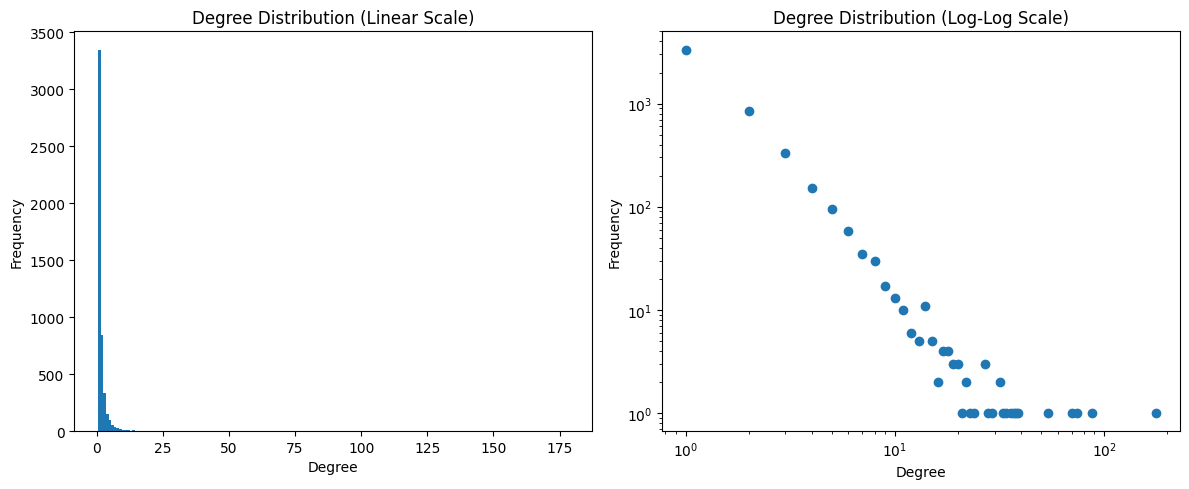

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(degree_histogram[1][:-1], degree_histogram[0], width=1)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution (Linear Scale)')

plt.subplot(1, 2, 2)
plt.loglog(degree_histogram[1][:-1], degree_histogram[0], marker='o', linestyle='None')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution (Log-Log Scale)')
plt.tight_layout()
plt.show()

_"**Fig. 4:** Degree distribution of the network. The left panel shows the distribution on a linear scale, highlighting the bulk of low-degree nodes. The right panel shows the same data on a log–log scale."_

## 1.2: Stats and visualization of the Rock Music Network

### 1.2.1: Explain your process in words

**Step-by-step process:**  
1. We first copied the Wikipedia page text listing the artists to a file `List_of_mainstream_rock_performers.txt`.  
2. Using a regular expression of the form `\[\[[^]]*\]\]`, we extracted the names of artists and bands.
   We filtered out non-artist links and saved the cleaned names as a list.  
3. We used the **MediaWiki API** to download the wikitext of each artist/group. For this:  
   - We constructed a URL with parameters specifying the action (`query`).
   - We included the artist name as the `titles` parameter.  
   - We added a `User-Agent` header to comply with Wikipedia’s robot policy.  
   - We allowed redirects so that pages pointing to another page would return the correct content, but printed who were those redirects to make sure they made sense.  
   - We corrected some file names by replacing spaces and filesystem-unfriendly characters with underscores. We also verified that no pages were missing due to e.g. incorrect title.
4. We used pandas to create an indexed dataframe of the artists and wikitexts. Using regex, we then added a word count as another column. For that we used regex to count only or mostly words and not numbers and other signs (regex: `\b[^\W\d_]+\b`).
5. We then created **directed graph** and iterated through all bands, adding an edge for each outgoing link. We got those links by iterating through a list of common elements of all rock bands and the found links (by using regex) in the specific wikitext.
6. After processing all pages, the graph was built. We extracted the **largest weakly connected component** and printed the number of nodes and edges before and after removing isolates. Few nodes were removed, indicating that most articles had at least one connection to another one.
7. We plotted the in-degree and out-degree distributions and computed statistics such as the most connected artists.  
8. Finally, we visualized the network using both **Kamada–Kawai** and another basic force-directed (spring) model (`nx.spring_layout`). Kamada–Kawai produced a clearer graph that better reflected network distances, despite indeed looking like a hairball due to all the edges present. Node size and word count information was effectively conveyed despite the messy graph.

**Most difficult part:**

The most difficult part for us was making a good overall strucure. We had several problems with the titles being in the wrong format, for example. And getting a good framework for iterating through all articles and correctly referencing its wikipage also gave us a headache, but using dataframe made this much easier.

**How we used LLMs:**

We used LLMs for harder regex expressions, fixing errors (for example using the wiki api), and code review when we couldnt spot the mistakes we made. We also used it to explain certain aspects of the process we were unclear on.

**What would we do differently:**

If we had to do it all again we would start by making a clear structure and framework. It is important to give clear variable names and not to reuse them later on as, especially in a notebook, this can lead to wrong results quickly. Also, keeping the notebook clean helps a lot with the overall process.

### 1.2.2: Simple network statistics and analysis

**First we generate the DiGraph from the previously generated csv file**

In [16]:
load_from_gml = False  # Set to True to import graph

if not load_from_gml:

    url = "https://raw.githubusercontent.com/Stonej29/02805/main/wikipages.csv"

    df = pd.read_csv(url)

    WRG = nx.DiGraph()

    for idx, row in df.iterrows():
        WRG.add_node(
            row["title"],
            words=row["words"]
        )
        wikipage = row["wikiarticle"]
        wikilinks = re.findall(r'\[\[[^]]*\]\]', wikipage)
        artists = list(set(wikilinks) & set(df["title"]))

        for artist in artists:
            if artist not in WRG:
                WRG.add_node(artist)
            WRG.add_edge(row["title"], artist)

    nx.write_gml(WRG, "rock_performers_network.gml")
    print(f"Graph built and saved: {WRG.number_of_nodes()} nodes, {WRG.number_of_edges()} edges.")
# Load graph directly from GML file
else:
    WRG = nx.read_gml("rock_performers_network.gml")
    print(f"Loaded graph has {WRG.number_of_nodes()} nodes and {WRG.number_of_edges()} edges.")

Graph built and saved: 488 nodes, 7098 edges.


In [17]:
# Remove disconnected nodes
WRG.remove_nodes_from(list(nx.isolates(WRG)))
print(f"After removing isolates, graph has {WRG.number_of_nodes()} nodes and {WRG.number_of_edges()} edges.")

# Extract the largest weakly connected component
largest_wcc_nodes = max(nx.weakly_connected_components(WRG), key=len)
WRG_lcc = WRG.subgraph(largest_wcc_nodes).copy()
print(f"Largest weakly connected component: {WRG_lcc.number_of_nodes()} nodes, {WRG_lcc.number_of_edges()} edges.")

After removing isolates, graph has 486 nodes and 7098 edges.
Largest weakly connected component: 486 nodes, 7098 edges.


**Now to the statistics**

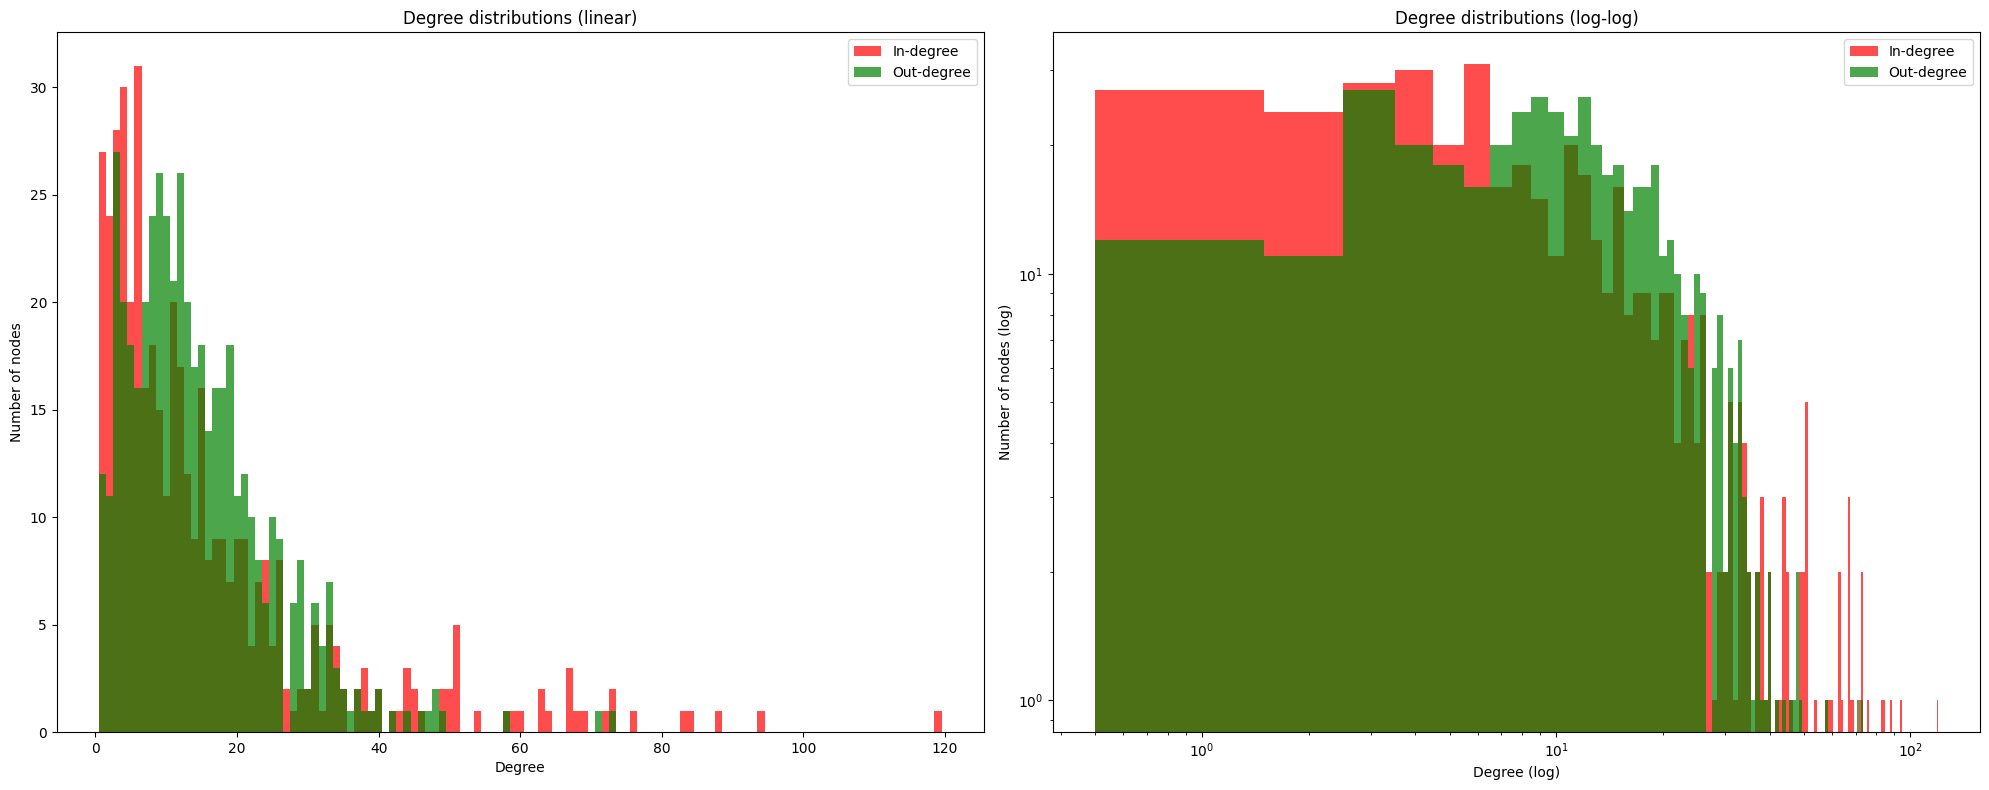

Median in-degree: 9.0
Median out-degree: 12.0


In [18]:
in_degrees = [d for _, d in WRG.in_degree()]
out_degrees = [d for _, d in WRG.out_degree()]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
bins = np.arange(1, max(max(in_degrees), max(out_degrees)) + 2) - 0.5

axes[0].hist(in_degrees, bins=bins, alpha=0.7, label="In-degree", color="red")
axes[0].hist(out_degrees, bins=bins, alpha=0.7, label="Out-degree", color="green")
axes[0].set_xlabel("Degree")
axes[0].set_ylabel("Number of nodes")
axes[0].set_title("Degree distributions (linear)")
axes[0].legend()

axes[1].hist(in_degrees, bins=bins, alpha=0.7, label="In-degree", color="red")
axes[1].hist(out_degrees, bins=bins, alpha=0.7, label="Out-degree", color="green")
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_xlabel("Degree (log)")
axes[1].set_ylabel("Number of nodes (log)")
axes[1].set_title("Degree distributions (log-log)")
axes[1].legend()

plt.tight_layout()
plt.show()

# Print mean and median for in-degree and out-degree
print(f"Median in-degree: {np.median(in_degrees)}")
print(f"Median out-degree: {np.median(out_degrees)}")

_**Fig. 5:** "In-degree and out-degree distributions of the network. Left: linear scal. Right: log–log scale."_

Both the in-degree and out-degree distributions are highly skewed. The median in-degree is 10, slightly lower than the median out-degree of 13, indicating that most artists reference more peers than the number of times they are referenced. The in-degree distribution has a much heavier tail, with a few "central" artists receiving many citations, over 60 in some cases, while most remain below 10. In contrast, only a handful of artists have an out-degree above 60. This difference likely arises because in-degree reflects popularity, capturing artists widely referenced across pages, whereas out-degree reflects the number of peers each artist chooses to mention, which is naturally more limited, as artists rarely link to large numbers of peers but are more likely to collectively reference the same prominent figures.

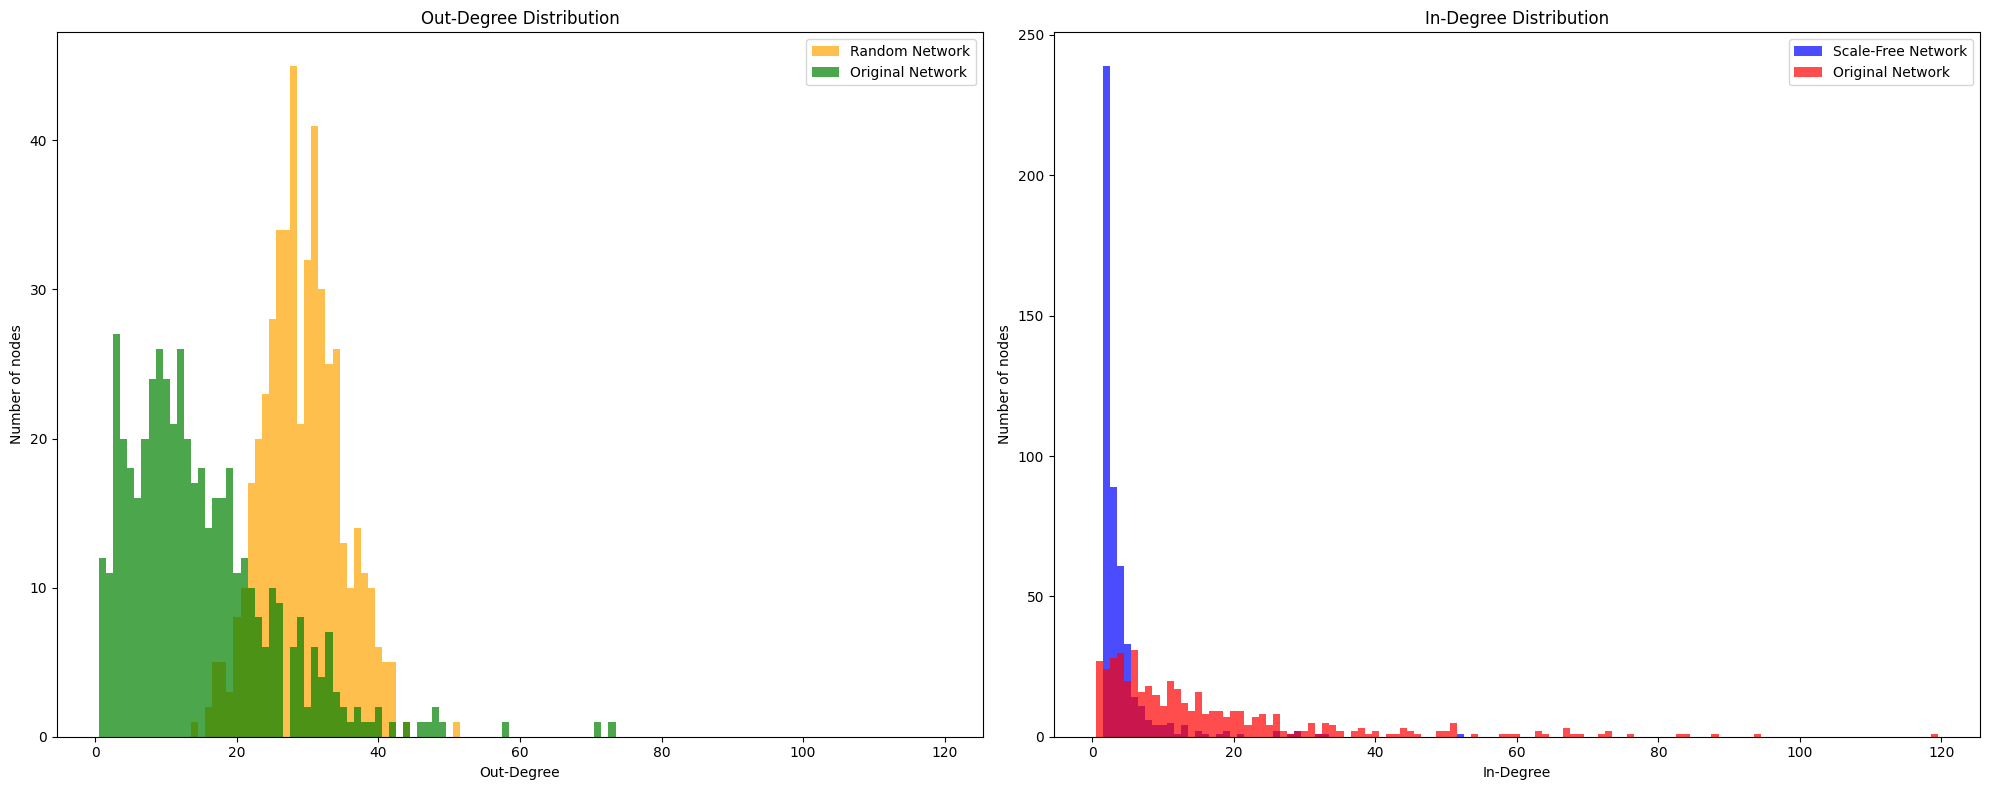

In [19]:
random_graph = nx.gnm_random_graph(WRG.number_of_nodes(), WRG.number_of_edges())
random_out_degrees = [d for n, d in random_graph.degree()]

scale_free_graph = nx.barabasi_albert_graph(WRG.number_of_nodes(), 2)
scale_free_in_degrees = [d for n, d in scale_free_graph.degree()]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].hist(random_out_degrees, bins=bins, color='orange', alpha=0.7, label='Random Network')
axes[0].hist(out_degrees, bins=bins, color='green', alpha=0.7, label='Original Network')
axes[0].set_title('Out-Degree Distribution')
axes[0].set_xlabel('Out-Degree')
axes[0].set_ylabel('Number of nodes')
axes[0].legend()

axes[1].hist(scale_free_in_degrees, bins=bins, color='blue', alpha=0.7, label='Scale-Free Network')
axes[1].hist(in_degrees, bins=bins, color='red', alpha=0.7, label='Original Network')
axes[1].set_title('In-Degree Distribution')
axes[1].set_xlabel('In-Degree')
axes[1].set_ylabel('Number of nodes')
axes[1].legend()

plt.tight_layout()
plt.show()

_**Fig. 6:** "Comparison of degree distributions. Left: out-degree distribution of the original network versus a random network with the same number of nodes and edges. Right: in-degree distribution of the original network versus a scale-free (Barabási–Albert) network with \(m=2\)."_

**Left:** In a random network with the same number of nodes and edges, the out-degree distribution is qualitatively similar but centered around 30, whereas the original network is centered around 10. Additionally, the random network shows a narrow, Poisson-like shape, which fails to capture the heavier tail of the original network where some nodes have significantly higher out-degrees.

**Right:** The scale-free network was generated with \(m=2\), meaning each new node attaches to 2 existing nodes. This is lower than the original network's average in-degree (~10), so the synthetic network underestimates connectivity. As a result, its distribution peaks sharply at 2 and declines very quickly, whereas the original in-degree distribution has a smoother shape with a longer tail, reflecting the presence of highly cited "central" artists.

In [20]:
in_deg = dict(WRG.in_degree())
out_deg = dict(WRG.out_degree())

top_in = sorted(in_deg.items(), key=lambda x: x[1], reverse=True)[:5]

top_out = sorted(out_deg.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 performers by in-degree:")
for node, deg in top_in:
    print(f"{node}: {deg}")

print("\nTop 5 performers by out-degree:")
for node, deg in top_out:
    print(f"{node}: {deg}")

Top 5 performers by in-degree:
[[Led Zeppelin]]: 119
[[Bob Dylan]]: 94
[[Queen (band)|Queen]]: 88
[[Metallica]]: 84
[[David Bowie]]: 83

Top 5 performers by out-degree:
[[Alice in Chains]]: 73
[[Deep Purple]]: 71
[[Black Sabbath]]: 58
[[Bryan Adams]]: 49
[[Guns N' Roses]]: 48


Artists with high in-degree likely shaped entire genres or influenced many successors, making them natural reference points. Those with high out-degree may belong to tightly knit scenes or have diverse collaborations, prompting frequent links to peers.

In [21]:
# Print top 10 nodes by word count
word_count_sorted = sorted(WRG.nodes(data='words'), key=lambda x: x[1], reverse=True)
print("\nTop 10 nodes by word count:")
for node, wc in word_count_sorted[:10]:
    print(f"{node}: {wc}")


Top 10 nodes by word count:
[[Guns N' Roses]]: 53915
[[Coldplay]]: 41527
[[Marilyn Manson (band)]]: 41050
[[Queen (band)|Queen]]: 40869
[[The Rolling Stones]]: 39163
[[Bob Dylan]]: 38320
[[David Bowie]]: 37764
[[Paul McCartney]]: 37551
[[U2]]: 37369
[[Elton John]]: 36700


As expected, longer wiki entries often correspond to the most influential or historically significant performers.

### 1.2.3: Let's build a simple visualization of the network

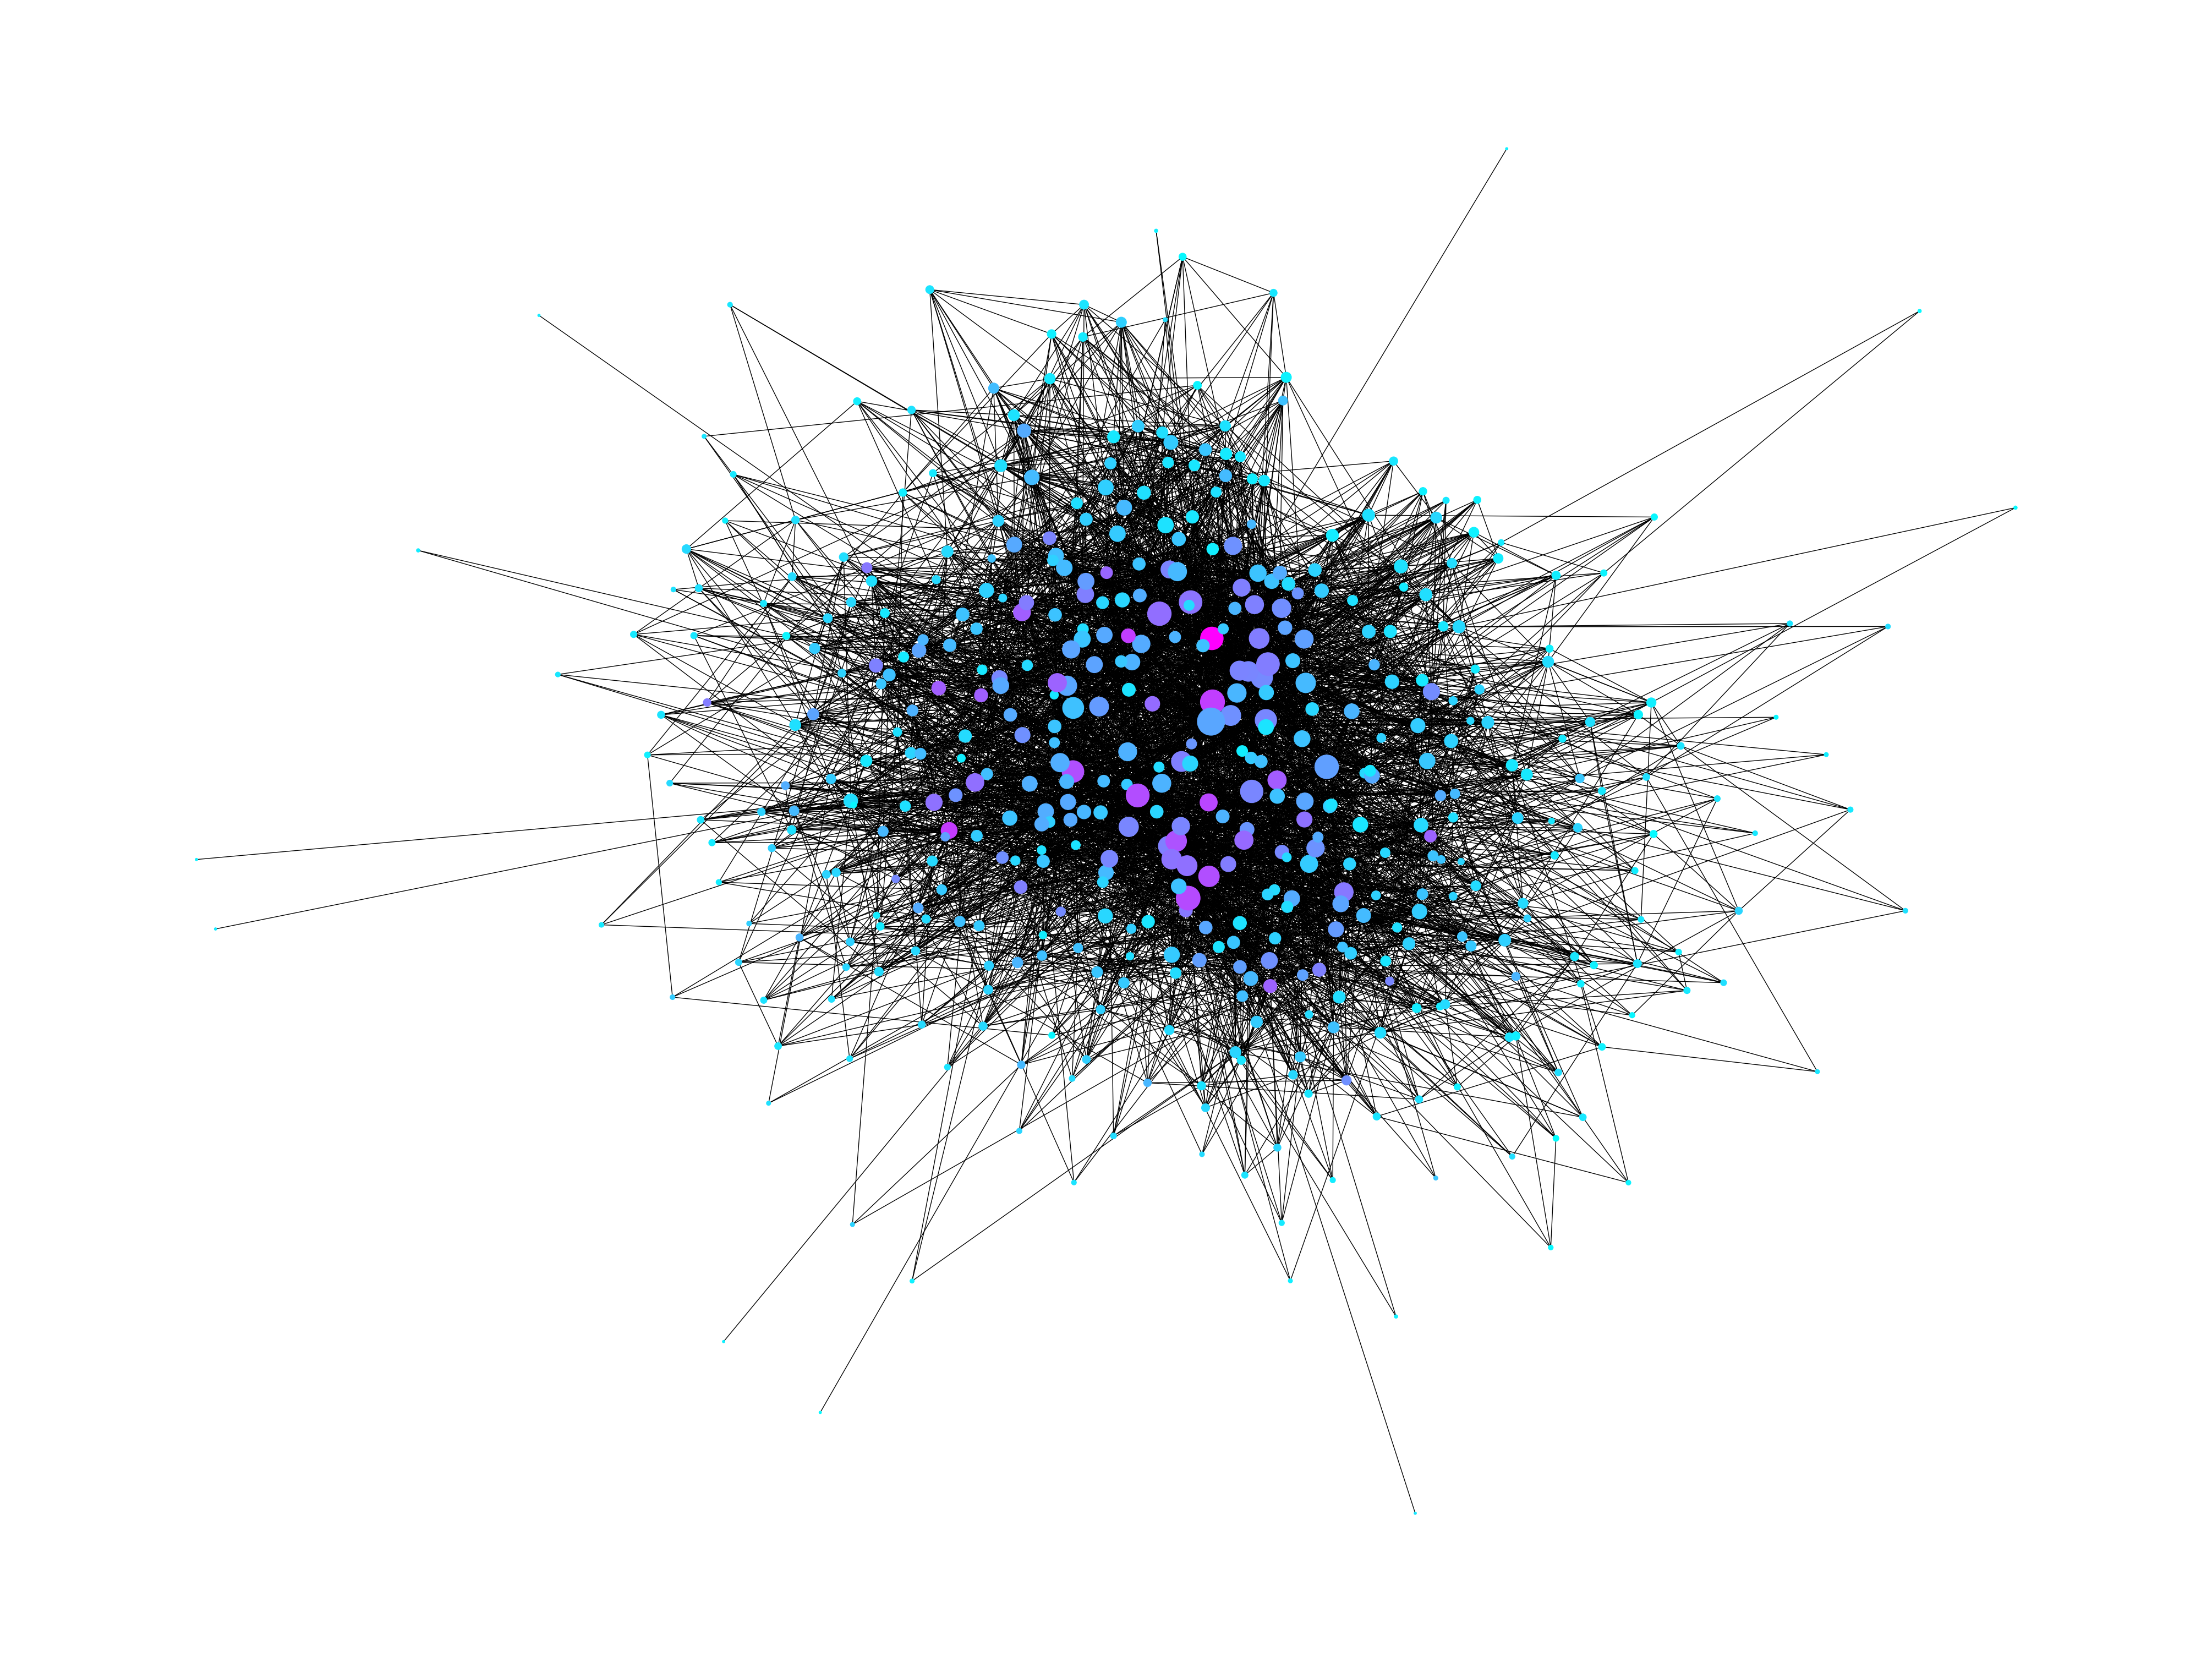

In [22]:
UWRG = WRG.to_undirected()

# Kamada-Kawai initial layout
kk_pos = nx.kamada_kawai_layout(UWRG)

# Improve with Fruchterman-Reingold using Kamada-Kawai as initial positions
fr_pos = nx.fruchterman_reingold_layout(UWRG, pos=kk_pos)

plt.figure(figsize=(40, 30))
nx.draw(
    UWRG,
    fr_pos,
    with_labels=False,
    node_size=[d * 10 for n, d in UWRG.degree()],
    node_color=[UWRG.nodes[n]['words'] for n in UWRG.nodes()],
    cmap=plt.cm.cool
)
plt.show()

_**Fig. 7:** "Visualization of the rock performers network using Kamada–Kawai initialized with Fruchterman–Reingold refinement. The graph resembles a "hairball" due to its large size and dense connectivity. Larger, more connected nodes tend to be more centrally located. Also, more central nodes usually correspond to longer pages (the more purple, the more longer)."_

## Contribution Statement

All group members contributed equally to this project. We each worked through all exercises individually, then came together to discuss solutions, share approaches, and refine our work. The final version reflects the combined effort and agreement of the entire team.